In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
df_train = pd.DataFrame(columns = ['text', 'rating', 'label'])
df_tets = pd.DataFrame(columns = ['text', 'rating', 'label'])

In [3]:
def read_data(purpose):
    df = pd.DataFrame(columns = ['text', 'rating', 'label'])
    for pos_neg in ['pos', 'neg']:
        path = 'C:/Users/duran/Downloads/aclImdb' + '/{}/{}'.format(purpose, pos_neg)
        label = 1 if pos_neg == 'pos' else 0
        for file in os.listdir(path):
            with open(os.path.join(path,file)) as f:
                try:
                    text = f.read()
                except UnicodeDecodeError:
                    continue
                    
                rating = file.split('_')[1].split('.')[0]
                df = df.append({'text': text, 'rating': rating, 'label' :label}, ignore_index=True)
    return df

In [4]:
df_train = read_data('train')
df_test = read_data('test')

(array([1.567e+03, 5.714e+03, 6.679e+03, 3.463e+03, 2.122e+03, 1.522e+03,
        1.015e+03, 7.230e+02, 5.770e+02, 3.940e+02, 3.010e+02, 2.160e+02,
        2.030e+02, 1.220e+02, 1.100e+02, 9.900e+01, 1.000e+02, 3.900e+01,
        7.000e+00, 3.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   52. ,   393.3,   734.6,  1075.9,  1417.2,  1758.5,  2099.8,
         2441.1,  2782.4,  3123.7,  3465. ,  3806.3,  4147.6,  4488.9,
         4830.2,  5171.5,  5512.8,  5854.1,  6195.4,  6536.7,  6878. ,
         7219.3,  7560.6,  7901.9,  8243.2,  8584.5,  8925.8,  9267.1,
         9608.4,  9949.7, 10291. , 10632.3, 10973.6, 11314.9, 11656.2,
        11997.5, 12338.8, 12680.1, 13021.4, 13362.7, 13704. ]),
 <a list of 40 Patch objects>)

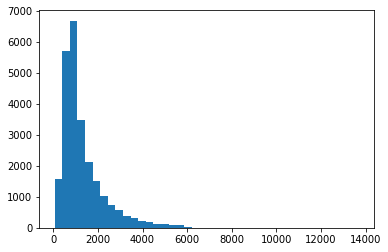

In [5]:
lengths = []
for _, row in df_train.iterrows():
    lengths.append(len(row['text']))
plt.hist(lengths, bins = 40)

In [6]:
nltk.download('stopwords')
def text_preprocessing(df):
    df_preprocessed = df.copy()
    corpus = []
    for _, row in df.iterrows():
        review = re.sub('[^a-zA-Z]', ' ', row['text'])
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        review = [ps(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    df_preprocessed['text'] = corpus
    return df_preprocessed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_train_preprocessed = text_preprocessing(df_train)
df_test_preprocessed = text_preprocessing(df_test)

In [ ]:
df_train_preprocessed.to_csv('preprocessed_train.csv')
df_test_preprocessed.to_csv('preprocessed_test.csv')

In [7]:
df_train_preprocessed = pd.read_csv('preprocessed_train.csv')
df_test_preprocessed = pd.read_csv('preprocessed_test.csv')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_train_preprocessed['text'].values, df_train_preprocessed[['rating','label']].values, test_size = 0.2, random_state = 0)

In [22]:
y_train_rat = y_train[:,0]
y_train_lab = y_train[:,1]

y_test_rat = y_test[:,0]
y_test_lab = y_test[:,1]

In [56]:
cv = CountVectorizer(max_features = 5000, ngram_range = (1,2)).fit(X_train)


In [61]:
X_train = cv.transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

In [13]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train_lab)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
clf.score(X_test,  y_test_lab)

0.8449689937987598

In [62]:
inp = Input(shape=(5000,))
x = Dense(256)(inp)
out = Dense(1, activation= 'linear')(x)
model = Model(inputs=[inp], outputs=out)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

In [63]:
hist = model.fit(X_train, y_train_rat, validation_split=0.1, epochs=10, batch_size=128, verbose =1)

Train on 17995 samples, validate on 2000 samples
Epoch 1/10
17995/17995 [==============================] - 1s 46us/sample - loss: 13.1811 - mae: 2.8162 - val_loss: 9.9104 - val_mae: 2.4595
Epoch 2/10
17995/17995 [==============================] - 1s 37us/sample - loss: 7.7180 - mae: 2.2102 - val_loss: 8.8066 - val_mae: 2.3298
Epoch 3/10
17995/17995 [==============================] - 1s 36us/sample - loss: 6.3404 - mae: 2.0187 - val_loss: 8.0343 - val_mae: 2.2379
Epoch 4/10
17995/17995 [==============================] - 1s 36us/sample - loss: 5.9541 - mae: 1.9464 - val_loss: 7.7723 - val_mae: 2.2290
Epoch 5/10
17995/17995 [==============================] - 1s 35us/sample - loss: 5.6200 - mae: 1.8915 - val_loss: 7.8442 - val_mae: 2.2392
Epoch 6/10
17995/17995 [==============================] - 1s 36us/sample - loss: 5.2117 - mae: 1.8408 - val_loss: 7.5052 - val_mae: 2.2012
Epoch 7/10
17995/17995 [==============================] - 1s 37us/sample - loss: 4.9892 - mae: 1.8134 - val_loss: 7.

In [64]:
preds = model.predict(X_test)

In [65]:
count = 0
for i in range(len(preds)):
    if preds[i] < 5 and y_test[:,1][i] == 0:
        count+=1
    if preds[i] > 5 and y_test[:,1][i] == 1:
        count+=1
print(count/len(preds))

0.8249649929985997


In [19]:
with open('imdb.vocab') as f:
    vocab = f.read().split('\n')
    
vocab = dict(zip(vocab, [*range(1,len(vocab)+1)]))

In [20]:
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [78]:
def text_preprocessing_for_word2vec(df):
    df_preprocessed = df.copy()
    corpus = []
    for _, row in df.iterrows():
        review = re.sub('[^a-zA-Z]', ' ', row['text'])
        review = review.lower()
        review = [word for word in review if not word in set(stopwords.words('english'))]
        corpus.append(review)
    df_preprocessed['text'] = corpus
    return df_preprocessed

In [ ]:
df_train_preprocessed = text_preprocessing_for_word2vec(df_train)

In [80]:
df_train_preprocessed.to_csv('pre_train.csv')

In [ ]:
df_train_preprocessed = pd.read_csv('pre_train.csv')

In [81]:
df_train_preprocessed['text'] = df_train_preprocessed.apply(lambda row: row['text'].split(' '), axis = 1)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_train_preprocessed['text'].values, df_train_preprocessed[['rating','label']].values, test_size = 0.2, random_state = 0)

In [83]:
sequences = [[vocab.get(wrd, 0) for wrd in comment] for comment in X_train]
test_sequences = [[vocab.get(wrd, 0)  for wrd in comment] 
                  for comment in X_test]

In [84]:
seq_len = 200

In [85]:
X_train = pad_sequences(sequences, maxlen=seq_len, 
                     padding="pre", truncating="post")

X_test = pad_sequences(test_sequences, maxlen=seq_len, 
                     padding="pre", truncating="post")

In [86]:
vm_dim = 100
nb_words = len(vocab)
wv_matrix = np.zeros((nb_words, vm_dim))
for word, i in vocab.items():
    try:
        wv_matrix[i] = embeddings_dict[word]
    except:
        pass  

In [89]:
wv_layer = Embedding(nb_words,
                     vm_dim,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=seq_len,
                     trainable=True)

comment_input = Input(shape=(seq_len,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)
x = Dropout(0.2)(x)
preds = Dense(1, activation='linear')(x)

model_nn = Model(inputs=[comment_input], outputs=preds)
model_nn.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

In [90]:
hist = model_nn.fit(X_train, y_train_rat, validation_split=0.1, epochs=10, batch_size=128, verbose =1)

Train on 17995 samples, validate on 2000 samples
Epoch 1/10
17995/17995 [==============================] - 12s 692us/sample - loss: 13.6242 - mae: 3.3317 - val_loss: 11.9562 - val_mae: 3.2440
Epoch 2/10
17995/17995 [==============================] - 10s 579us/sample - loss: 10.8051 - mae: 2.9488 - val_loss: 9.5320 - val_mae: 2.7515
Epoch 3/10
17995/17995 [==============================] - 10s 575us/sample - loss: 9.6753 - mae: 2.6907 - val_loss: 7.0588 - val_mae: 2.1906
Epoch 4/10
17995/17995 [==============================] - 11s 589us/sample - loss: 6.0376 - mae: 1.9317 - val_loss: 6.0646 - val_mae: 1.9574
Epoch 5/10
17995/17995 [==============================] - 10s 582us/sample - loss: 4.2895 - mae: 1.5685 - val_loss: 4.8099 - val_mae: 1.6539
Epoch 6/10
17995/17995 [==============================] - 11s 587us/sample - loss: 3.3522 - mae: 1.3747 - val_loss: 4.7269 - val_mae: 1.5995
Epoch 7/10
17995/17995 [==============================] - 10s 577us/sample - loss: 2.6629 - mae: 1.220

In [91]:
preds = model_nn.predict(X_test)

In [92]:
count = 0
for i in range(len(preds)):
    if preds[i] < 5 and y_test[:,1][i] == 0:
        count+=1
    if preds[i] > 5 and y_test[:,1][i] == 1:
        count+=1
print(count/len(preds))

0.8449689937987598
